In [7]:
#importing libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Model

**Important Note**

This code will only work fine, if you enter your PDE is the following format:
u = f(u_x,u_t)

Which means that you have to re-organize the order of your PDE and isolate u which is a dependent variable, while both x and t are independent.

Also this model is trained based on the exact solution of one PDE, so you have to provide the exact solution for your PDE (considering its very own boundary conditions) and the solution must be entered in a python-code format.





In [12]:
#Correct example for PDE format : u = 2*u_x + u_t + 8
ux_part = int(input("Please enter the coefficients of the u_x part of your PDE : "))
ut_part = int(input("Please enter the coefficients of the u_t part of your PDE : "))
constant = input("Please enter the coefficients of the constant part of your PDE : ")
#intervals
x_start , x_end = map(int,input('Please enter the start and the end of the x-axis interval : ').split()) #BVPs
t_start , t_end = map(int,input('Please enter the start and the end of the time interval : ').split())
sol_bound = input('Please enter  the the exact solution for boundary conditions : ')

Please enter the coefficients of the u_x part of your PDE : -1
Please enter the coefficients of the u_t part of your PDE : 3
Please enter the coefficients of the constant part of your PDE : 0
Please enter the start and the end of the x-axis interval : 0 4
Please enter the start and the end of the time interval : 0 1
Please enter  the the exact solution for boundary conditions : np.sin(x - t/3) * np.exp(-t/3)


In [13]:
#get the exact solution as a function
def sol(x,t):
    return eval(sol_bound)

In [10]:
#Model Architecture
class PINN_Model(nn.Module):
    def __init__(self):
        super(PINN_Model, self).__init__()
        self.hidden_layer1 = nn.Linear(2,10)
        self.hidden_layer2 = nn.Linear(10,10)
        self.hidden_layer3 = nn.Linear(10,10)
        self.hidden_layer4 = nn.Linear(10,10)
        self.hidden_layer5 = nn.Linear(10,10)
        self.output_layer = nn.Linear(10,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output
model = PINN_Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

In [11]:
#Loss functions
def loss_pde(x,t, model, ux_part, ut_part, constant):
    u = model(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = (ux_part * u_x) + (ut_part * u_t) - u
    return pde
mse_cost_function = torch.nn.MSELoss()

In [15]:
#generate training data
X_b = np.random.uniform(low=float(x_start),high = float(x_end) , size=(300,1))
T_b = np.zeros((300,1))
U_b = sol(X_b,0) #get the solution for u(x,0) (aka boundary)

In [16]:
num_epochs = 2000
loss_values = [] #for storing traning loss during each epoch
for epoch in range(1,num_epochs+1):
    start_time = time.time()
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on boundary conditions
    X_bound = Variable(torch.from_numpy(X_b).float(), requires_grad=False).to(device)
    T_bound = Variable(torch.from_numpy(T_b).float(), requires_grad=False).to(device)
    U_bound = Variable(torch.from_numpy(U_b).float(), requires_grad=False).to(device)
    model_bound = model(X_bound, T_bound) # output of u(x,t)
    mse_u = mse_cost_function(model_bound, U_bound)
    # Loss based on PDE
    x_collocation = np.random.uniform(low=float(x_start),high = float(x_end) , size=(300,1))
    t_collocation = np.random.uniform(low=float(t_start),high = float(t_end) , size=(300,1))
    all_zeros = np.zeros((300,1))
    X_col = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    T_col = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    lossPDE = loss_pde(X_col, T_col, model, ux_part, ut_part, constant) # output of f(x,t)
    mse_f = mse_cost_function(lossPDE, all_zeros)
    # Combining the loss functions to get the whole loss
    loss = mse_u + mse_f
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()
    elapsed_time = time.time() - start_time
    with torch.autograd.no_grad():
    	print(f"Epoch: {epoch}/{num_epochs} Training Loss: {loss.data:.4f} Time Spent: {elapsed_time:.2f} seconds")

Epoch: 1/2000 Training Loss: 0.7030 Time Spent: 0.21 seconds
Epoch: 2/2000 Training Loss: 0.6891 Time Spent: 0.01 seconds
Epoch: 3/2000 Training Loss: 0.6754 Time Spent: 0.01 seconds
Epoch: 4/2000 Training Loss: 0.6621 Time Spent: 0.01 seconds
Epoch: 5/2000 Training Loss: 0.6490 Time Spent: 0.01 seconds
Epoch: 6/2000 Training Loss: 0.6363 Time Spent: 0.01 seconds
Epoch: 7/2000 Training Loss: 0.6239 Time Spent: 0.01 seconds
Epoch: 8/2000 Training Loss: 0.6118 Time Spent: 0.01 seconds
Epoch: 9/2000 Training Loss: 0.6000 Time Spent: 0.01 seconds
Epoch: 10/2000 Training Loss: 0.5886 Time Spent: 0.01 seconds
Epoch: 11/2000 Training Loss: 0.5774 Time Spent: 0.01 seconds
Epoch: 12/2000 Training Loss: 0.5666 Time Spent: 0.01 seconds
Epoch: 13/2000 Training Loss: 0.5561 Time Spent: 0.01 seconds
Epoch: 14/2000 Training Loss: 0.5459 Time Spent: 0.01 seconds
Epoch: 15/2000 Training Loss: 0.5361 Time Spent: 0.01 seconds
Epoch: 16/2000 Training Loss: 0.5265 Time Spent: 0.01 seconds
Epoch: 17/2000 Tr

#Visualization

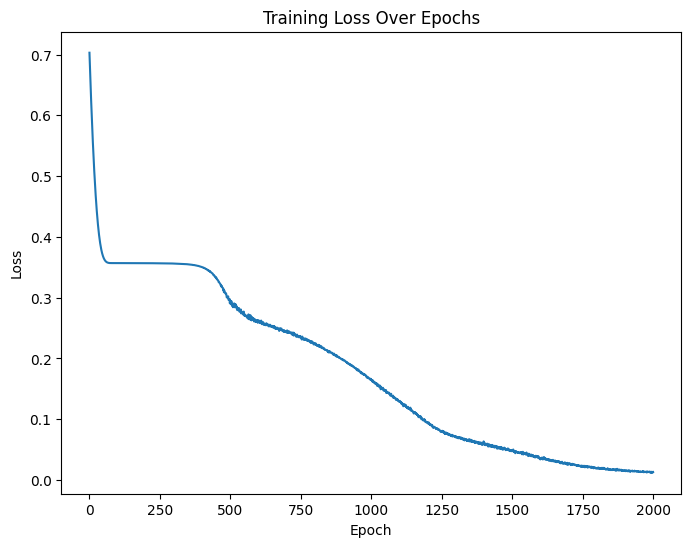

In [17]:
#Loss Tracking
plt.figure(figsize=(8, 6))
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

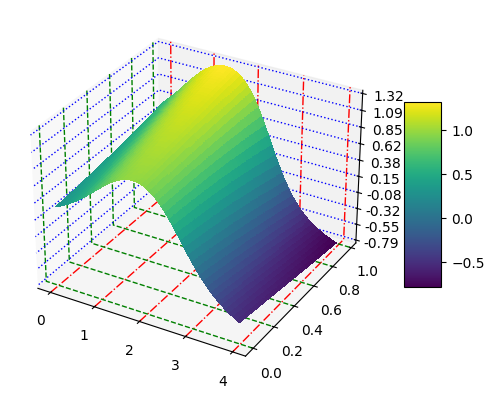

In [18]:
#Plot the figure which shows the value of u predicted by the model with its corresponding inputs (x,t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=np.arange(x_start,x_end,0.02)
t=np.arange(t_start,t_end,0.02)
#create the mesh grid
MeshX, MeshT = np.meshgrid(x, t)
x = np.ravel(MeshX).reshape(-1,1)
t = np.ravel(MeshT).reshape(-1,1)
PX = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
PT = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
#get the predicted values for all x and t pairs in the domain of the question
PU = model(PX,PT)
u=PU.data.cpu().numpy()
MeshU = u.reshape(MeshX.shape)
surf = ax.plot_surface(MeshX,MeshT,MeshU, cmap=cm.viridis,linewidth=0, antialiased=False)
#adjust the plot configurations
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.xaxis._axinfo["grid"].update(color='red', linestyle='-.', linewidth=1.0)
ax.yaxis._axinfo["grid"].update(color='green', linestyle='--', linewidth=1.0)
ax.zaxis._axinfo["grid"].update(color='blue', linestyle=':', linewidth=1.0)
plt.show()